# Can a computer learn if we're going to detect gravitational waves?

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import h5py

import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

C:\Users\utente\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5','r')
list(dataset.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [3]:
X = []
for i in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']:
    X.append(dataset[i][:100000])

X=np.array(X).T

In [4]:
print(X)

[[-0.3072008   0.27616489 -0.43075952 ...  0.62478004 -3.11678443
   2.13965943]
 [-0.7347119  -0.49849269 -0.29816229 ...  0.98665033  1.36029119
   2.43870712]
 [-0.05783062 -0.70379617 -0.35451167 ...  0.28619935  0.07997326
   1.86946125]
 ...
 [ 0.65272199 -0.02226377  0.13214517 ...  0.72273304  0.44419445
   0.73558851]
 [-0.13497691  0.01640865 -0.20757182 ...  0.45948906 -0.41532972
   0.39483305]
 [-0.05363359 -0.63317114  0.00473647 ...  0.8265149   1.23350759
   0.41619384]]


In [5]:
y =np.array(dataset['det'][:100000])

In [6]:
print(y)

[0 0 0 ... 1 1 1]


In [7]:
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.30,random_state=24)

In [8]:
print(X_train)

[[ 0.09008814 -0.11425539  0.77947041 ...  0.93738635 -3.11015882
   1.8731113 ]
 [-0.13123841  0.02530232  0.28866087 ...  0.60689175 -0.19019222
   1.03573875]
 [-0.3120416  -0.11206641  0.07401486 ...  0.23007149 -2.61714291
   3.25966868]
 ...
 [-0.35801162  0.02993766 -0.25772094 ...  0.63714841 -0.87142757
   3.46790962]
 [-0.64254465 -0.00502777  0.32718608 ...  0.17312629 -0.98827713
   0.37822736]
 [ 0.62181026 -0.15195012  0.05759864 ...  0.13261333 -3.00439123
   0.48018288]]


### Decision Tree Classifier

In [9]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth=10,random_state=24)
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=24)

**Confusion matrix**

In [10]:
# confusion matrix
y_pred=dt.predict(X_test)
ConfusionMatrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = ConfusionMatrix.ravel()
print(ConfusionMatrix)
print("True Negative = ",tn)
print("False Positive = ",fp)
print("False Negative = ",fn)
print("True Positive = ",tp)

[[25049   616]
 [  657  3678]]
True Negative =  25049
False Positive =  616
False Negative =  657
True Positive =  3678


In [11]:
contamination = fp / (tp + fp)
efficency = 1 -contamination

print("Contamination = ",contamination)
print("Efficency = ",efficency)

Contamination =  0.14345598509548207
Efficency =  0.8565440149045179


**ROC curve**

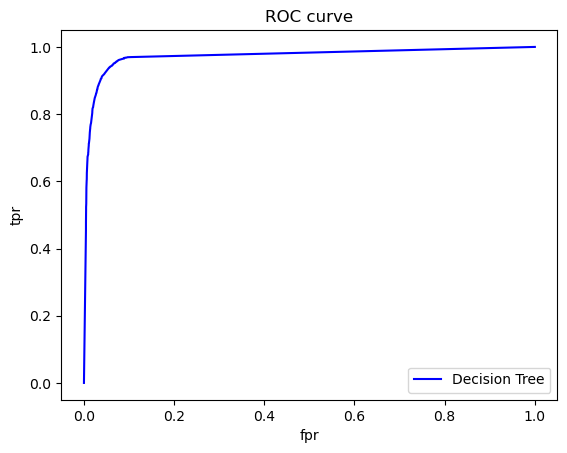

In [12]:
# ROC curve
y_prob = dt.predict_proba(X_test) [:,1]
fpr_dt, tpr_dt, threshold = roc_curve(y_test, y_prob)

#print(threshold)

plt.plot(fpr_dt,tpr_dt,color='blue',label='Decision Tree')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.legend()
plt.show()

**Validation test**

  0%|          | 0/19 [00:00<?, ?it/s]

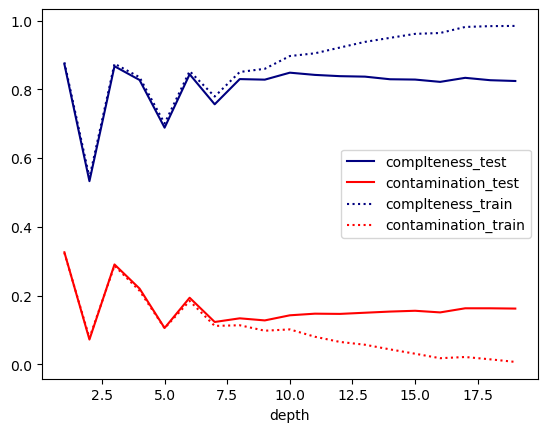

In [13]:
depth = np.arange(1,20)
complteness_test = []
contamination_test = []
complteness_train = []
contamination_train= []


for d in tqdm(depth):
    dt = DecisionTreeClassifier(max_depth = d, criterion='entropy')
    dt.fit(X_train,y_train)
    
    # confusion matrix - y_test
    y_pred=dt.predict(X_test)
    ConfusionMatrix = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = ConfusionMatrix.ravel()
    
    complteness_test.append(tp / (tp + fn))
    contamination_test.append(fp / (tp + fp))
    
    # confusion matrix - y_train
    y_pred=dt.predict(X_train)
    ConfusionMatrix = confusion_matrix(y_train,y_pred)
    tn, fp, fn, tp = ConfusionMatrix.ravel()
    
    complteness_train.append(tp / (tp + fn))
    contamination_train.append(fp / (tp + fp))
    

plt.plot(depth,complteness_test,color='navy',label='complteness_test')
plt.plot(depth,contamination_test,color='red',label='contamination_test')
plt.plot(depth,complteness_train,color='navy',ls='dotted',label='complteness_train')
plt.plot(depth,contamination_train,color='red',ls='dotted',label='contamination_train')
plt.xlabel("depth")
plt.legend()
plt.show()

### Random Forest classifier

In [14]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 6, criterion='entropy',n_jobs =-1)
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200,
                       n_jobs=-1)

**Confusion matrix**

In [15]:
# confusion matrix
y_pred=rf.predict(X_test)
ConfusionMatrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = ConfusionMatrix.ravel()
print(ConfusionMatrix)
print("True Negative = ",tn)
print("False Positive = ",fp)
print("False Negative = ",fn)
print("True Positive = ",tp)
print(y_test,y_pred)

[[25328   337]
 [  931  3404]]
True Negative =  25328
False Positive =  337
False Negative =  931
True Positive =  3404
[0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]


In [16]:
contamination = fp / (tp + fp)
efficency = 1 -contamination

print("Contamination = ",contamination)
print("Efficency = ",efficency)

Contamination =  0.0900828655439722
Efficency =  0.9099171344560278


**ROC curve**

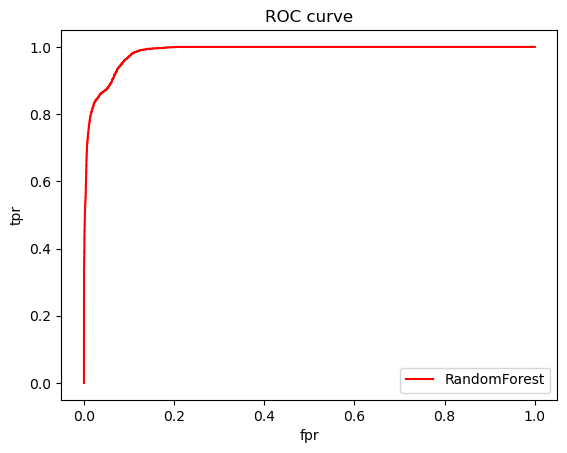

In [17]:
# ROC curve
y_prob = rf.predict_proba(X_test) [:,1]
fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_prob)

#print(threshold)

plt.plot(fpr_rf,tpr_rf, color='red',label='RandomForest')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.legend()
plt.show()

**Validation test**

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\utente\AppData\Local\Temp\ipykernel_17892\3371910462.py:17: RuntimeWarning: invalid value encountered in scalar divide
  contamination_test.append(fp / (tp + fp))
C:\Users\utente\AppData\Local\Temp\ipykernel_17892\3371910462.py:17: RuntimeWarning: invalid value encountered in scalar divide
  contamination_test.append(fp / (tp + fp))


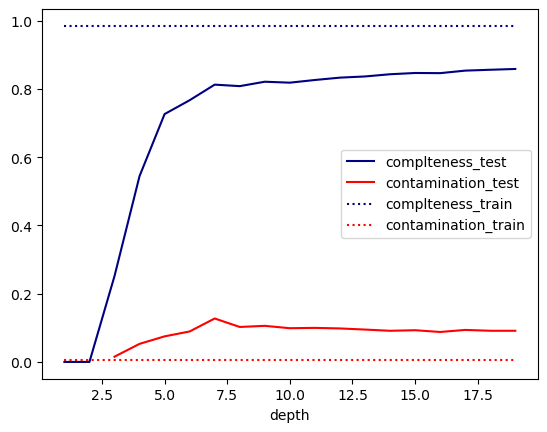

In [18]:
depth = np.arange(1,20)
complteness_test = []
contamination_test = []
complteness_train = []
contamination_train= []

for d in tqdm(depth):
    rf = RandomForestClassifier( max_depth = d, criterion='entropy',n_jobs =-1)
    rf.fit(X_train,y_train)
    
    # confusion matrix
    y_pred=rf.predict(X_test)
    ConfusionMatrix = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = ConfusionMatrix.ravel()
    
    complteness_test.append(tp / (tp + fn))
    contamination_test.append(fp / (tp + fp))
    
    # confusion matrix - y_train
    y_pred=rf.predict(X_train)
    ConfusionMatrix = confusion_matrix(y_train,y_pred)
    tn, fp, fn, tp = ConfusionMatrix.ravel()
    
    complteness_train.append(tp / (tp + fn))
    contamination_train.append(fp / (tp + fp))
    

plt.plot(depth,complteness_test,color='navy',label='complteness_test')
plt.plot(depth,contamination_test,color='red',label='contamination_test')
plt.plot(depth,complteness_train,color='navy',ls='dotted',label='complteness_train')
plt.plot(depth,contamination_train,color='red',ls='dotted',label='contamination_train')
plt.xlabel("depth")
plt.legend()
plt.show()

### Gradient Boosting Classifier

In [20]:
gb =  GradientBoostingClassifier(n_estimators=200, max_depth=7, random_state=24)
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=24)

**Confusion matrix**

In [21]:
# confusion matrix
y_pred=gb.predict(X_test)
ConfusionMatrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = ConfusionMatrix.ravel()
print(ConfusionMatrix)
print("True Negative = ",tn)
print("False Positive = ",fp)
print("False Negative = ",fn)
print("True Positive = ",tp)

[[25339   326]
 [  434  3901]]
True Negative =  25339
False Positive =  326
False Negative =  434
True Positive =  3901


In [22]:
contamination = fp / (tp + fp)
efficency = 1 -contamination

print("Contamination = ",contamination)
print("Efficency = ",efficency)

Contamination =  0.07712325526378046
Efficency =  0.9228767447362195


**ROC curve**

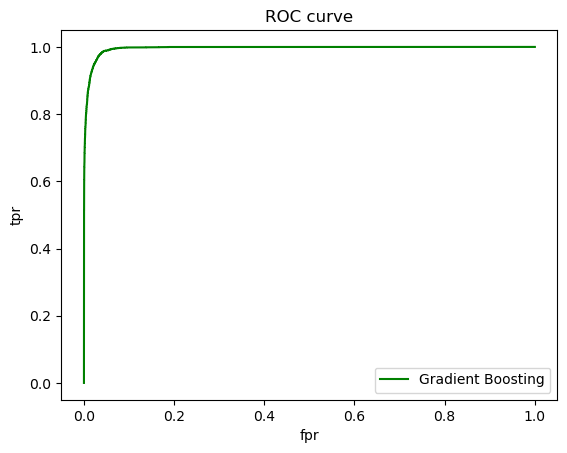

In [23]:
# ROC curve
y_prob = gb.predict_proba(X_test) [:,1]
fpr_gb, tpr_gb, threshold = roc_curve(y_test, y_prob)

#print(threshold)

plt.plot(fpr_gb,tpr_gb, color='green',label='Gradient Boosting')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.legend()
plt.show()

**Validation test**

  0%|          | 0/19 [00:00<?, ?it/s]

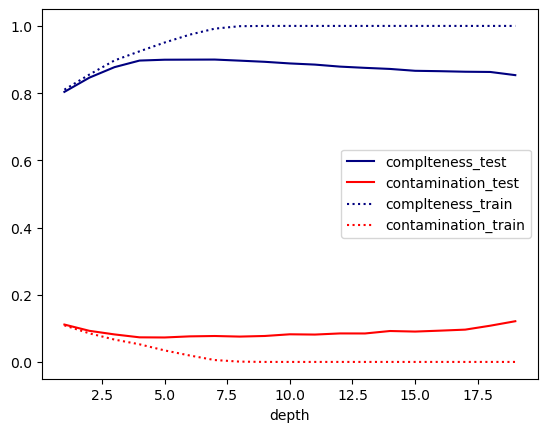

In [26]:
depth = np.arange(1,20)
complteness_test = []
contamination_test = []
complteness_train = []
contamination_train= []

for d in tqdm(depth):
    gb =  GradientBoostingClassifier(n_estimators=200, max_depth=d, random_state=24)
    gb.fit(X_train,y_train)
    
    # confusion matrix
    y_pred=gb.predict(X_test)
    ConfusionMatrix = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = ConfusionMatrix.ravel()
    
    complteness_test.append(tp / (tp + fn))
    contamination_test.append(fp / (tp + fp))
    
    # confusion matrix - y_train
    y_pred=gb.predict(X_train)
    ConfusionMatrix = confusion_matrix(y_train,y_pred)
    tn, fp, fn, tp = ConfusionMatrix.ravel()
    
    complteness_train.append(tp / (tp + fn))
    contamination_train.append(fp / (tp + fp))
    

plt.plot(depth,complteness_test,color='navy',label='complteness_test')
plt.plot(depth,contamination_test,color='red',label='contamination_test')
plt.plot(depth,complteness_train,color='navy',ls='dotted',label='complteness_train')
plt.plot(depth,contamination_train,color='red',ls='dotted',label='contamination_train')
plt.xlabel("depth")
plt.legend()
plt.show()

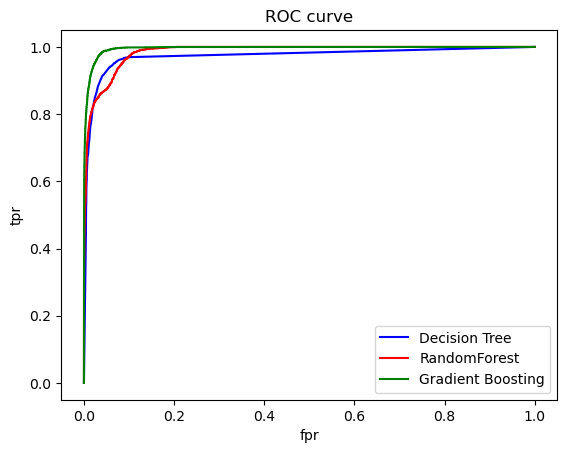

In [25]:
plt.plot(fpr_dt,tpr_dt,color='blue',label='Decision Tree')
plt.plot(fpr_rf,tpr_rf, color='red',label='RandomForest')
plt.plot(fpr_gb,tpr_gb, color='green',label='Gradient Boosting')

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.legend()
plt.show()

---
---

In [27]:
X = []
for i in ['mtot', 'z']:
    X.append(dataset[i][:100000])

X = np.array(X).T
y = np.array(dataset['det'][:100000])

In [28]:
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,test_size=0.30,random_state=24)

In [29]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth=10,random_state=24)
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=24)

In [30]:
# confusion matrix
y_pred=dt.predict(X_test)
ConfusionMatrix = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = ConfusionMatrix.ravel()
print(ConfusionMatrix)
print("True Negative = ",tn)
print("False Positive = ",fp)
print("False Negative = ",fn)
print("True Positive = ",tp)

[[25029   636]
 [  996  3339]]
True Negative =  25029
False Positive =  636
False Negative =  996
True Positive =  3339


In [31]:
contamination = fp / (tp + fp)
efficency = 1 -contamination

print("Contamination = ",contamination)
print("Efficency = ",efficency)

Contamination =  0.16
Efficency =  0.84


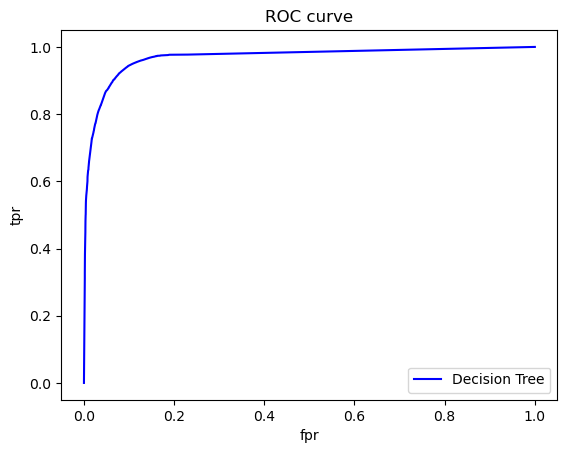

In [32]:
# ROC curve
y_prob = dt.predict_proba(X_test) [:,1]
fpr_dt, tpr_dt, threshold = roc_curve(y_test, y_prob)

#print(threshold)

plt.plot(fpr_dt,tpr_dt,color='blue',label='Decision Tree')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.legend()
plt.show()